In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import pandas as pd

In [4]:
data = pd.read_csv('C:/Users/Aravind/PROJECTS/Enefit-Predicting-Energy-Behavior/Enefit/data/external/electricity_prices.csv')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15286 entries, 0 to 15285
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   forecast_date  15286 non-null  object 
 1   euros_per_mwh  15286 non-null  float64
 2   origin_date    15286 non-null  object 
 3   data_block_id  15286 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 477.8+ KB


In [11]:
path = 'C:/Users/Aravind/PROJECTS/Enefit-Predicting-Energy-Behavior/Enefit/data/external/electricity_prices.csv'
df = pd.read_csv(path , parse_dates=['forecast_date'])

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15286 entries, 0 to 15285
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   forecast_date  15286 non-null  datetime64[ns]
 1   euros_per_mwh  15286 non-null  float64       
 2   origin_date    15286 non-null  object        
 3   data_block_id  15286 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 477.8+ KB


In [13]:
df = df.sort_values("forecast_date").set_index("forecast_date")
df = df.drop(['origin_date','data_block_id'] , axis=1)
df = df.drop_duplicates()

In [14]:
df.head()

,euros_per_mwh
forecast_date,
2021-09-01 00:00:00,92.51
2021-09-01 01:00:00,88.90
2021-09-01 02:00:00,87.35
2021-09-01 03:00:00,86.88
2021-09-01 04:00:00,88.43


In [15]:
df.tail()

,euros_per_mwh
forecast_date,
2023-05-30 13:00:00,57.36
2023-05-30 14:00:00,19.63
2023-05-30 15:00:00,13.10
2023-05-30 17:00:00,9.55
2023-05-30 23:00:00,-1.29


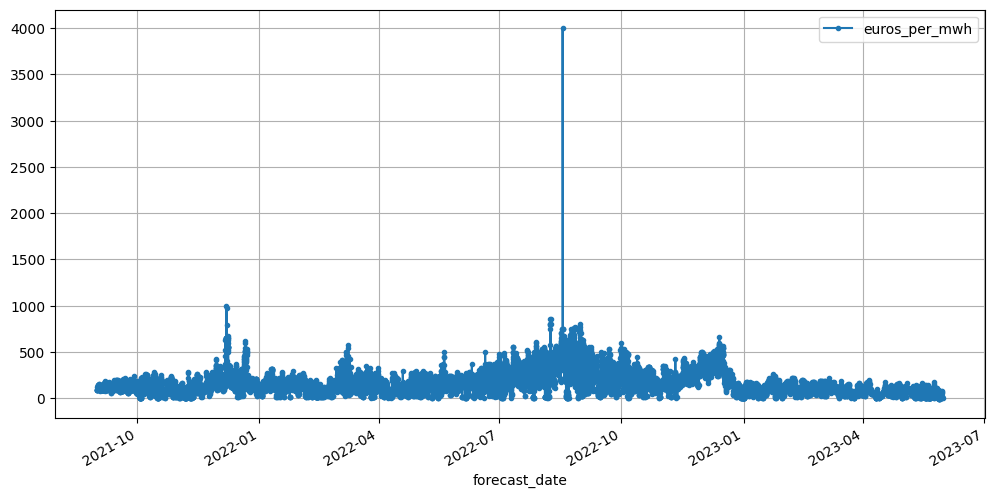

In [16]:
import matplotlib.pyplot as plt

df[:].plot(grid=True , marker='.' , figsize=(12,6))
plt.show()

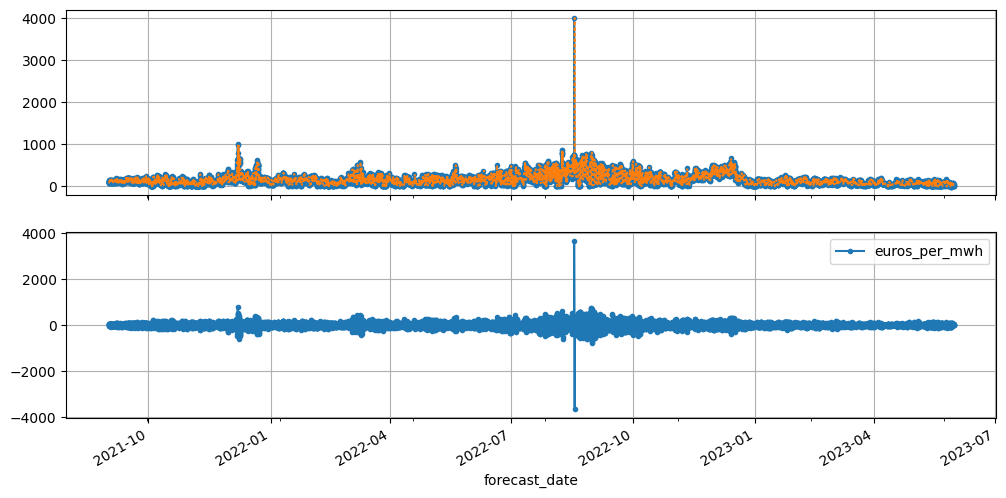

In [17]:
diff_7 = df[['euros_per_mwh']].diff(7)[:]

fig , axs = plt.subplots(2,1,sharex=True,figsize=(12,6))
df.plot(ax=axs[0] , legend=False , marker='.')
df.shift(7).plot(ax=axs[0] , grid=True , legend=False , linestyle=':')
diff_7.plot(ax=axs[1] , grid=True , marker='.')
plt.show()

In [18]:
diff_7.abs().mean()

euros_per_mwh    80.681924
dtype: float64

In [19]:
targets = df[['euros_per_mwh']][:]
(diff_7 / targets).abs().mean()

euros_per_mwh    inf
dtype: float64

In [21]:
train = df["euros_per_mwh"]["2021-09-01":"2022-10-06"] 
valid = df["euros_per_mwh"]["2022-10-07":"2023-01-29"] 
test = df["euros_per_mwh"]["2023-05-30":]

In [22]:
import tensorflow as tf

seq_length = 30
tf.random.set_seed(42)
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    train.to_numpy(),
    targets=train[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    valid.to_numpy(),
    targets=valid[seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

In [23]:
def fit_and_evaluate(model, train_set, valid_set, learning_rate=0.01, epochs=20):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience=50, restore_best_weights=True)
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9 , nesterov=True)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs,
                        callbacks=[early_stopping_cb])
    valid_loss, valid_mae = model.evaluate(valid_set)
    return valid_mae

In [25]:
tf.random.set_seed(42)
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(128, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(128),
    tf.keras.layers.Dense(1)
])

In [26]:
fit_and_evaluate(model, train_ds, valid_ds)

Epoch 1/20
236/236 [==============================] - 3s 8ms/step - loss: 94.7267 - mae: 95.2252 - val_loss: 108.2418 - val_mae: 108.7407
Epoch 2/20
236/236 [==============================] - 2s 7ms/step - loss: 91.4663 - mae: 91.9649 - val_loss: 107.6630 - val_mae: 108.1607
Epoch 3/20
236/236 [==============================] - 2s 7ms/step - loss: 91.5062 - mae: 92.0045 - val_loss: 108.0657 - val_mae: 108.5639
Epoch 4/20
236/236 [==============================] - 2s 7ms/step - loss: 91.3824 - mae: 91.8807 - val_loss: 107.8593 - val_mae: 108.3569
Epoch 5/20
236/236 [==============================] - 2s 7ms/step - loss: 91.4483 - mae: 91.9464 - val_loss: 107.4330 - val_mae: 107.9313
Epoch 6/20
236/236 [==============================] - 2s 7ms/step - loss: 91.4198 - mae: 91.9182 - val_loss: 106.9980 - val_mae: 107.4969
Epoch 7/20
236/236 [==============================] - 2s 6ms/step - loss: 91.4869 - mae: 91.9851 - val_loss: 108.4018 - val_mae: 108.9009
Epoch 8/20
236/236 [==============

111.81208801269531

In [27]:
tf.random.set_seed(42)
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(1)
])

In [29]:
fit_and_evaluate(model, train_ds, valid_ds)

Epoch 1/20


236/236 [==============================] - 9s 30ms/step - loss: 96.9927 - mae: 97.4915 - val_loss: 106.4336 - val_mae: 106.9314
Epoch 2/20
236/236 [==============================] - 7s 27ms/step - loss: 91.7590 - mae: 92.2572 - val_loss: 108.2977 - val_mae: 108.7963
Epoch 3/20
236/236 [==============================] - 6s 27ms/step - loss: 91.3187 - mae: 91.8172 - val_loss: 108.3142 - val_mae: 108.8132
Epoch 4/20
236/236 [==============================] - 6s 26ms/step - loss: 91.3620 - mae: 91.8610 - val_loss: 108.7823 - val_mae: 109.2813
Epoch 5/20
236/236 [==============================] - 7s 28ms/step - loss: 100.3952 - mae: 100.8937 - val_loss: 139.9891 - val_mae: 140.4884
Epoch 6/20
236/236 [==============================] - 6s 27ms/step - loss: 93.0853 - mae: 93.5835 - val_loss: 108.0042 - val_mae: 108.5023
Epoch 7/20
236/236 [==============================] - 7s 29ms/step - loss: 91.3382 - mae: 91.8364 - val_loss: 107.4275 - val_mae: 107.9255
Epoch 8/20
236/236 [================

107.82899475097656